In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to c:\users\marti\appdata\local\temp\pip-req-build-kqinzsgm
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git 'C:\Users\marti\AppData\Local\Temp\pip-req-build-kqinzsgm'

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Monte Carlo Agent

We chose an on-policy first-visit MC control (p123).

In [2]:
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import gym
import pandas as pd
import seaborn as sns

In [3]:
class OPMCAgent:
    def __init__(self, gamma, epsilon=0.1):
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Small value for epsilon in epsilon-soft policy
        self.Q = defaultdict(lambda: np.zeros(2))  # Initialize Q(s, a)
        self.returns = defaultdict(list)  # Initialize Returns(s, a)

    def choose_action(self, state):
        """ Chooses an action using the epsilon-greedy policy (which is a epsilon-soft policy). """
        if np.random.rand() < self.epsilon:
            return np.random.choice([0, 1])
        else:
            return np.argmax(self.Q[state])

    def generate_episode(self, env):
        """ Generates an episode using the epsilon-greedy policy. """
        episode = []
        state, _ = env.reset()
        done = False
        while not done:
            action = self.choose_action(state)
            next_state, reward, done, _, info = env.step(action)
            episode.append((state, action, reward, info['score']))
            state = next_state
        return episode

    def train(self, env, n_episodes):
        """ Trains the agent on the environment. """
        rewards = []
        scores = []
        for _ in tqdm(range(n_episodes), desc='Training'):
            episode = self.generate_episode(env)
            G = 0
            for t in reversed(range(len(episode))):
                state, action, reward, _ = episode[t]
                G = self.gamma * G + reward
                if not any(x[0] == state and x[1] == action for x in episode[:t]):
                    self.returns[(state, action)].append(G)
                    self.Q[state][action] = np.mean(self.returns[(state, action)])
            rewards.append(sum([r for (_, _, r, _) in episode]))  
            scores.append(episode[-1][-1])  

        return rewards, scores
    
    def test(self,env, n_episodes):
        rewards = []
        scores=[]
        for i in tqdm(range(n_episodes)):
            state, _ = env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = np.argmax([self.Q[state][0],self.Q[state][1]]) #greedy policy now
                next_state, reward, done, _, info = env.step(action)
                episode_reward += reward
                state = next_state
                if info['score'] > 5_000: # We have mastered the game
                    break
            rewards.append(episode_reward)
            scores.append(info['score'])
        return rewards, scores

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training: 100%|██████████| 10000/10000 [03:57<00:00, 42.08it/s]


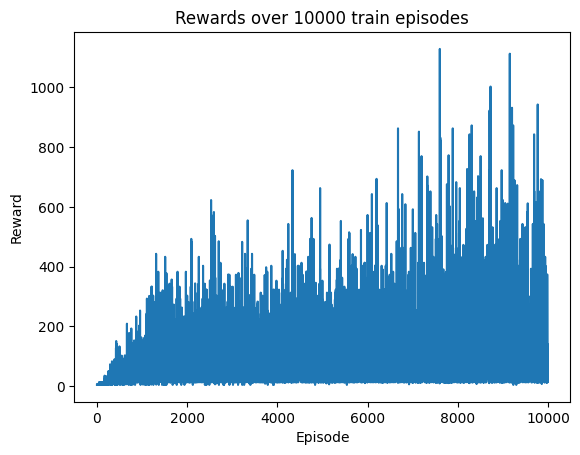

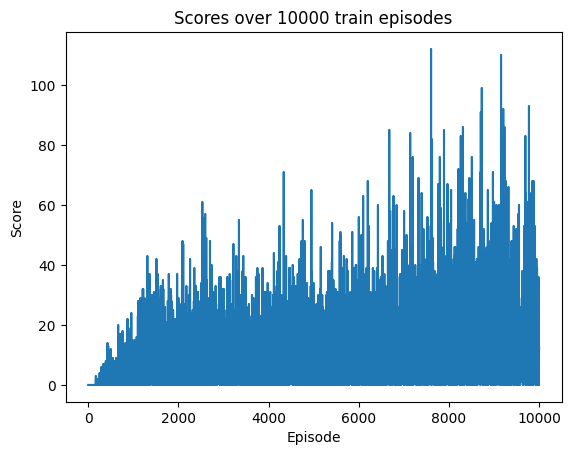

In [193]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
n_ep = 10_000
opmc_agent = OPMCAgent(gamma=0.9, epsilon=0.1)
train_rewards, train_scores = opmc_agent.train(env, n_ep)

# rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_ep} train episodes")
plt.show()

# scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_ep} train episodes")
plt.show()


We see that over the first 3000 episodes, we seem to have an improvement in the average reward and score. This is due to the Q real values learning. However because of the epsilon random choice, the score never get really high.

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]

Average reward over 10 test episodes: 50014.0
Median reward over 10 test episodes: 50014.0
Average scores over 10 test episodes: 5001.0
Median scores over 10 test episodes: 5001.0


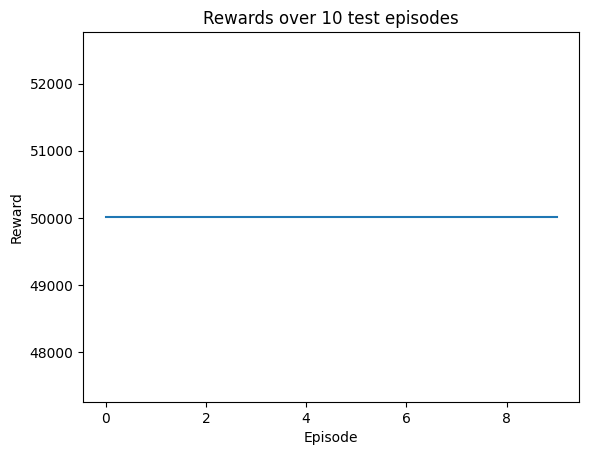

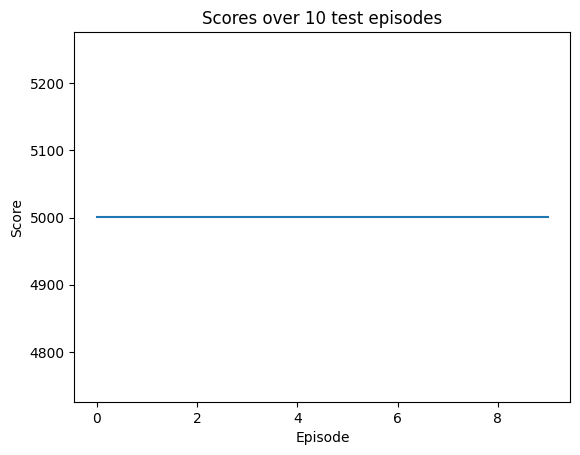

In [175]:
# test the trained MCAgent 
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
n_tests = 10
test_rewards, test_scores = opmc_agent.test(env, n_tests)

# rewards
plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_ep} test episodes")
plt.show()

# scores
plt.plot(test_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_ep} test episodes")
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 400.09it/s]


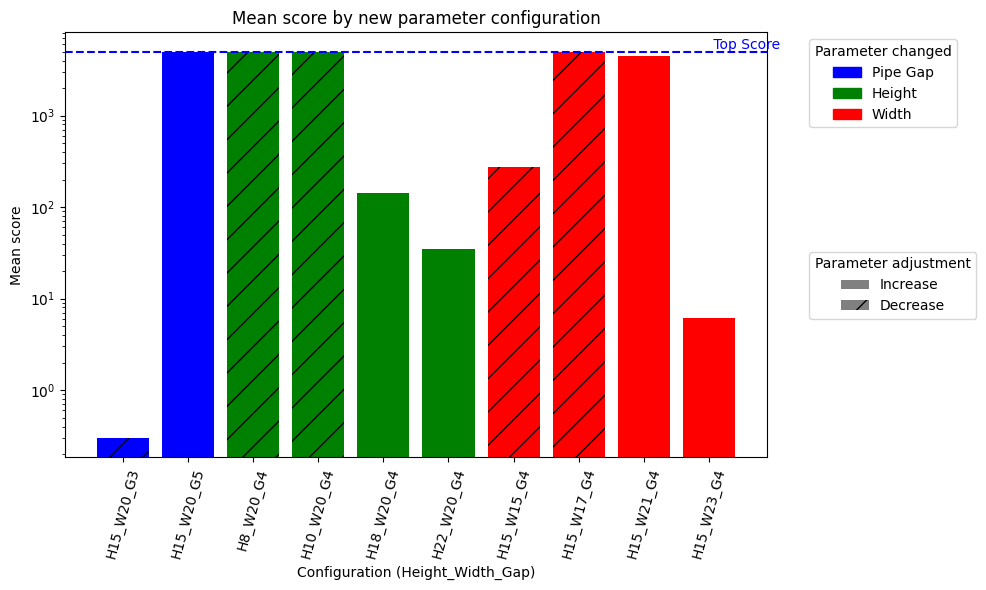

In [198]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Assuming the opmc_agent and its test method are correctly defined and implemented

configs = [
    [15, 20, 3], [15, 20, 5],  # different pipe gap
    [8, 20, 4], [10, 20, 4], [18, 20, 4], [22, 20, 4],  # different height
    [15, 15, 4], [15, 17, 4], [15, 21, 4], [15, 23, 4],  # different width
]

upgrade = [False, True,
           False, False, True, True,
           False, False, True, True
           ]

colors = ['blue', 'blue',  # Pipe gap
          'green', 'green', 'green', 'green', # Height
          'red', 'red', 'red', 'red'  # Width
          ]

color_meanings = {
    'blue': 'Pipe Gap',
    'green': 'Height',
    'red': 'Width'
}

hatch_meanings = {
    '/': 'Decrease',
    '': 'Increase'
}

avg_scores_configs = {}

for elem in configs:
    env = gym.make('TextFlappyBird-v0', height=elem[0], width=elem[1], pipe_gap=elem[2])
    n_tests = 10
    test_rewards, test_scores = opmc_agent.test(env, n_tests)  # Assuming this method exists
    avg_scores_configs["H{}_W{}_G{}".format(*elem)] = np.mean(test_scores)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_labels = list(avg_scores_configs.keys())
bar_values = avg_scores_configs.values()

# Create bars with different colors and hatches
for i, (label, value, color, upg) in enumerate(zip(bar_labels, bar_values, colors, upgrade)):
    hatch = '/' if not upg else '' 
    ax.bar(i, value, label=label, color=color, hatch=hatch)

ax.set_xticks(range(len(avg_scores_configs)))
ax.set_xticklabels(bar_labels, rotation=75)
ax.set_xlabel('Configuration (Height_Width_Gap)')
ax.set_ylabel('Mean score')
ax.set_title('Mean score by new parameter configuration')
ax.set_yscale("log")

ax.axhline(y=5000, color='b', linestyle='--')
ax.text(x=len(avg_scores_configs)-1, y=5000, s=" Top Score", color='b', verticalalignment='bottom')

color_patches = [mpatches.Patch(color=color, label=meaning) for color, meaning in color_meanings.items()]
hatch_patches = [mpatches.Patch(facecolor='gray', hatch=hatch, label=meaning) for hatch, meaning in hatch_meanings.items()]
legend1 = plt.legend(handles=color_patches, title="Parameter changed", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().add_artist(legend1)
plt.legend(handles=hatch_patches, title="Parameter adjustment", bbox_to_anchor=(1.05, 0.75), loc='upper left')
plt.tight_layout() 
plt.show()


### Parameters tuning: 

In [208]:
import time

num_ep_list = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
eps_list = [0.05, 0.1, 0.15, 0.2, 0.3]

eps_perf = {}
eps_times = {}

for eps in eps_list:
    print('Epsilon:', eps)
    score_eps = []
    times_eps = []
    for num_ep in num_ep_list:
        t1 = time.time()
        run_scores = []
        for run in range(20):
            print(f'Run {run+1} for epsilon {eps} with {num_ep} episodes')
            env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
            opmc_agent = OPMCAgent(gamma=0.9, epsilon=eps)
            opmc_agent.train(env, num_ep)
            _, test_scores = opmc_agent.test(env, 10)
            run_scores.append(np.mean(test_scores))
        avg_run_score = np.mean(run_scores)
        score_eps.append(avg_run_score)
        t2 = time.time()
        times_eps.append((t2 - t1)/20)
    eps_perf[eps] = score_eps
    eps_times[eps] = times_eps

100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Run 9 for epsilon 0.3 with 4500 episodes


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Run 10 for epsilon 0.3 with 4500 episodes


100%|██████████| 10/10 [00:00<00:00, 21.83it/s]


Run 11 for epsilon 0.3 with 4500 episodes


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Run 12 for epsilon 0.3 with 4500 episodes


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Run 13 for epsilon 0.3 with 4500 episodes


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Run 14 for epsilon 0.3 with 4500 episodes


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Run 15 for epsilon 0.3 with 4500 episodes


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


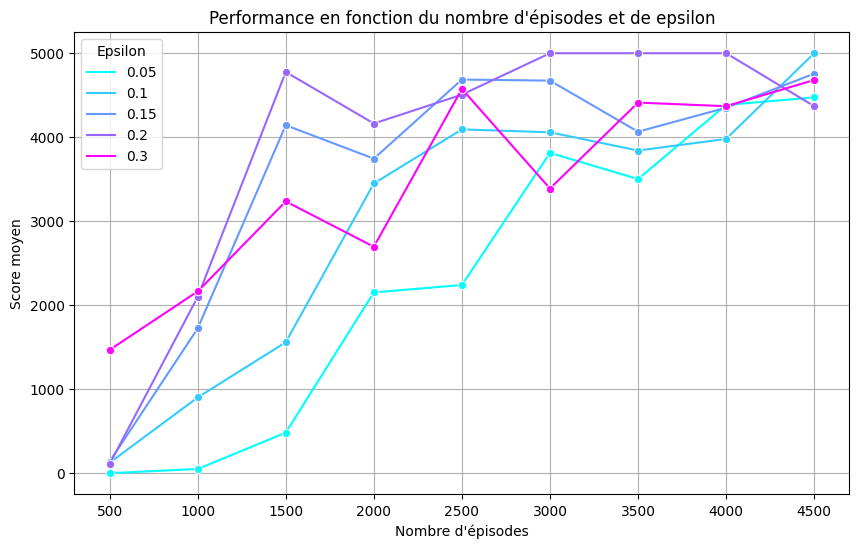

In [209]:
import seaborn as sns
import pandas as pd

data = []
for eps, scores in eps_perf.items():
    for num_ep, score in zip(num_ep_list, scores):
        data.append({'eps': eps, 'num_ep': num_ep, 'score': score})
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='num_ep', y='score', hue='eps', palette='cool', marker='o')

plt.title("Performance en fonction du nombre d'épisodes et de epsilon")
plt.xlabel("Nombre d'épisodes")
plt.ylabel('Score moyen')
plt.legend(title='Epsilon')
plt.grid(True)

plt.show()

In [ ]:
num_ep_list = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
gammas_list = [0.5, 0.7, 0.8, 0.9, 0.95]

gammas_perf = {}

for gamma in gammas_list:
    score_gamma = []
    for num_ep in num_ep_list:
        run_scores = []
        for run in range(20):
            env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
            opmc_agent = OPMCAgent(gamma=gamma, epsilon=0.15)
            opmc_agent.train(env, num_ep)
            _, test_scores = opmc_agent.test(env, 10)
            run_scores.append(np.mean(test_scores))

        avg_run_score = np.mean(run_scores)
        score_gamma.append(avg_run_score)
    gammas_perf[gamma] = score_gamma

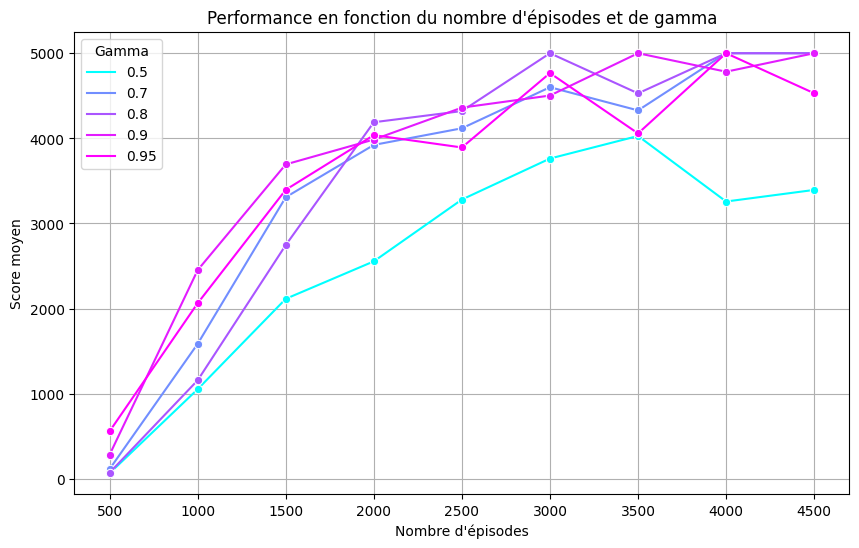

In [211]:
import seaborn as sns
import pandas as pd

data2 = []
for gamma, scores in gammas_perf.items():
    for num_ep, score in zip(num_ep_list, scores):
        data2.append({'gamma': gamma, 'num_ep': num_ep, 'score': score})
df2 = pd.DataFrame(data2)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df2, x='num_ep', y='score', hue='gamma', palette='cool', marker='o')

plt.title("Performance en fonction du nombre d'épisodes et de gamma")
plt.xlabel("Nombre d'épisodes")
plt.ylabel('Score moyen')
plt.legend(title='Gamma')
plt.grid(True)

plt.show()

In [42]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
opmc_agent = OPMCAgent(gamma=0.9, epsilon=0.1)
_, _ = opmc_agent.train(env, 18_000)

Training: 100%|██████████| 18000/18000 [25:31<00:00, 11.75it/s]


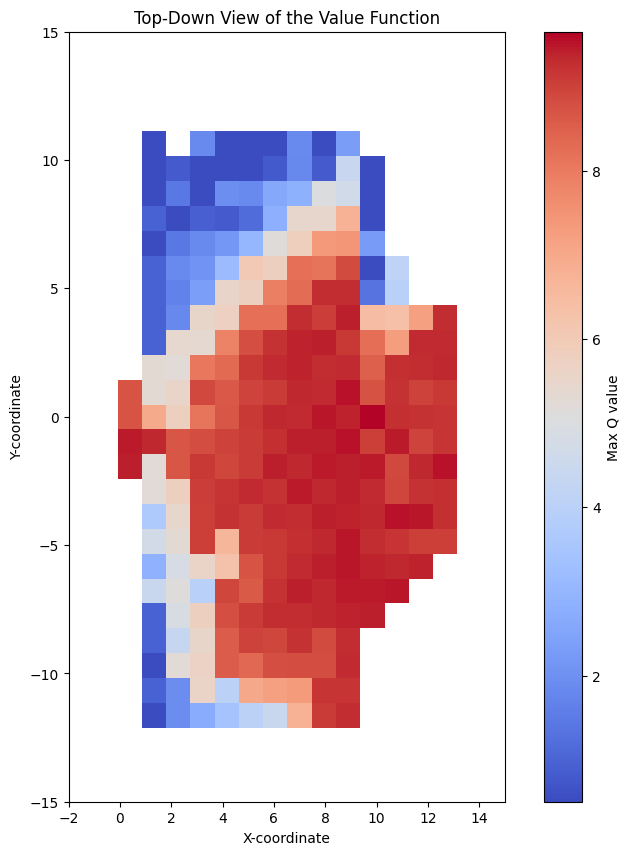

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming sl_agent is an instance of SarsaLambdaAgent that has been trained

def plot_top_view_value_function(agent, min_x = -2, max_x = 15, min_y = -15, max_y = 15):
    """
    Plots the top-down view of the value function from the Q-table of an agent.
    
    Args:
        agent (SarsaLambdaAgent): The agent to plot the value function for.
        min_x (int): The minimum x-coordinate in the environment state space.
        max_x (int): The maximum x-coordinate in the environment state space.
        min_y (int): The minimum y-coordinate in the environment state space.
        max_y (int): The maximum y-coordinate in the environment state space.
    """

    grid = np.full((max_y - min_y + 1, max_x - min_x + 1), np.nan)

    for state, q_values in agent.Q.items():
        x, y = state
        grid_x = x - min_x
        grid_y = y - min_y
        if min_x <= x <= max_x and min_y <= y <= max_y:
            grid[grid_y, grid_x] = np.mean(q_values)  

    # Plot the grid as an image
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap=plt.get_cmap('coolwarm'), interpolation='nearest', origin='lower', extent=[min_x, max_x, min_y, max_y])
    plt.colorbar(label='Max Q value')
    plt.title('Top-Down View of the Value Function')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.show()


plot_top_view_value_function(opmc_agent)

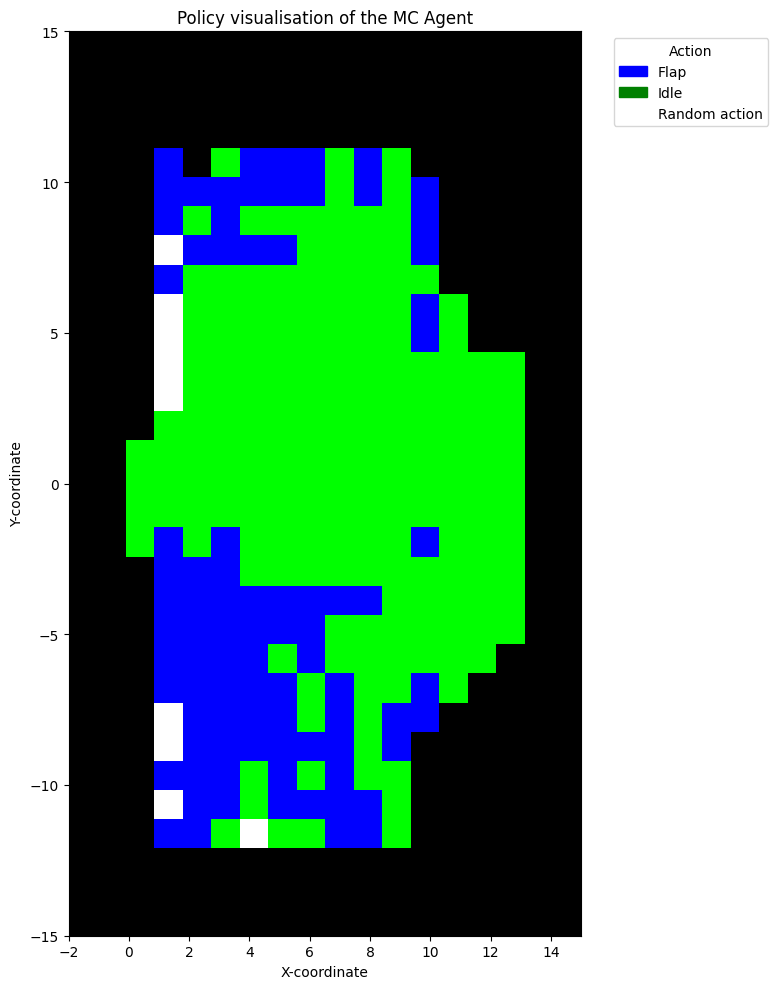

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_view_comparison(agent, min_x=-2, max_x=15, min_y=-15, max_y=15):
    """
    Plots the top-down view comparing q_value[0] and q_value[1] from the Q-table of an agent.
    
    Args:
        agent (SarsaLambdaAgent): The agent to plot the value function for.
        min_x (int): The minimum x-coordinate in the environment state space.
        max_x (int): The maximum x-coordinate in the environment state space.
        min_y (int): The minimum y-coordinate in the environment state space.
        max_y (int): The maximum y-coordinate in the environment state space.
    """
    grid = np.zeros((max_y - min_y + 1, max_x - min_x + 1, 3))  # For RGB colors

    for state, q_values in agent.Q.items():
        x, y = state
        grid_x = x - min_x
        grid_y = y - min_y
        if min_x <= x <= max_x and min_y <= y <= max_y:
            if q_values[0] > q_values[1]:
                grid[grid_y, grid_x] = [0, 0, 1]  # Blue
            elif q_values[1] > q_values[0]:
                grid[grid_y, grid_x] = [0, 1, 0]  # Green
            else:  # If they are equal or both 0
                grid[grid_y, grid_x] = [1, 1, 1]  

    # Plot the grid as an image
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, interpolation='nearest', origin='lower', extent=[min_x, max_x, min_y, max_y])
    plt.title('Policy visualisation of the MC Agent')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')

    import matplotlib.patches as mpatches
    blue_patch = mpatches.Patch(color='blue', label='Flap')
    green_patch = mpatches.Patch(color='green', label='Idle')
    white_patch = mpatches.Patch(color='white', label='Random action')
    plt.legend(handles=[blue_patch, green_patch, white_patch], title = "Action", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

plot_top_view_comparison(opmc_agent)


## Second Agent : Sarsa($\lambda$)

Training: 100%|██████████| 10000/10000 [09:15<00:00, 18.01it/s]


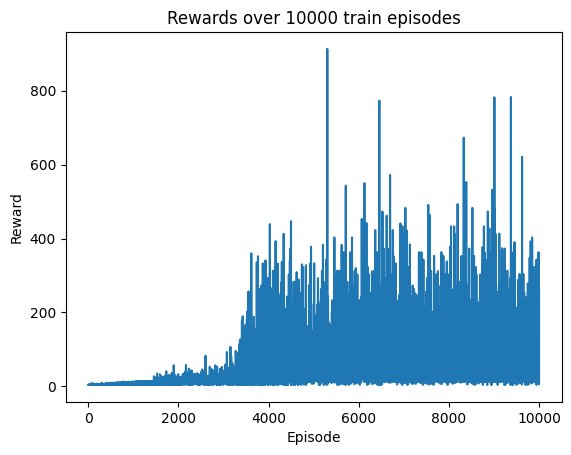

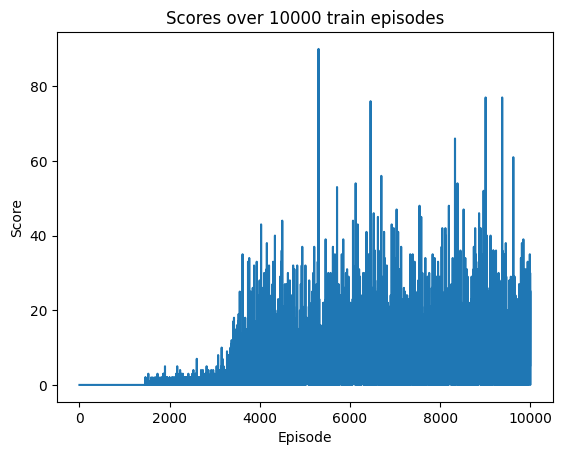

In [4]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import text_flappy_bird_gym
import gymnasium as gym


class SarsaLambdaAgent:
    def __init__(self, gamma=0.9, alpha=0.15, epsilon=0.1, lambda_value=0.9, action_space=2):
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.lambda_value = lambda_value
        self.Q = defaultdict(lambda: np.zeros(action_space))
        self.E = defaultdict(lambda: np.zeros(action_space))
        self.action_space = action_space

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.Q[state])

    def reset_traces(self):
        self.E.clear()

    def update(self, state, action, reward, next_state=None, next_action=None):
        delta = reward - self.Q[state][action]
        if next_state is not None and next_action is not None:
            delta += self.gamma * self.Q[next_state][next_action]
        self.E[state][action] += 1
        
        for s in self.Q:
            for a in range(len(self.Q[s])):
                self.Q[s][a] += self.alpha * delta * self.E[s][a]
                self.E[s][a] *= self.gamma * self.lambda_value

    def train(self, env, episodes):
        rewards = []
        scores = []
        for episode_num in tqdm(range(1, episodes + 1), desc='Training'):
            self.reset_traces()
            state, _ = env.reset()
            action = self.choose_action(state)
            done = False
            episode_rewards = []
            while not done:
                next_state, reward, done, _, info = env.step(action)
                next_action = self.choose_action(next_state) if not done else None
                self.update(state, action, reward, next_state, next_action)
                state, action = next_state, next_action
                episode_rewards.append(reward)
            rewards.append(sum(episode_rewards))
            scores.append(info['score'])  # Assuming 'score' is in 'info'
        return rewards, scores

    def test(self, env, episodes):
        self.epsilon = 0  # No exploration
        test_rewards = []
        test_scores = []
        for _ in tqdm(range(episodes), desc='Testing'):
            state, _ = env.reset()
            done = False
            episode_rewards = []
            while not done:
                action = self.choose_action(state)
                state, reward, done, _, info = env.step(action)
                episode_rewards.append(reward)
                if info['score'] > 5000:
                    break
            test_rewards.append(sum(episode_rewards))
            test_scores.append(info['score'])
        self.epsilon = 0.1
        return test_rewards, test_scores


env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
n_ep = 10_000
sl_agent = SarsaLambdaAgent()
train_rewards, train_scores = sl_agent.train(env, n_ep)

# rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_ep} train episodes")
plt.show()

# scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_ep} train episodes")
plt.show()


Testing: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


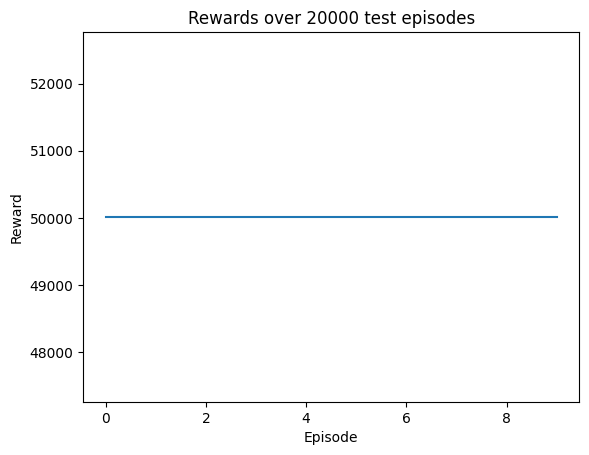

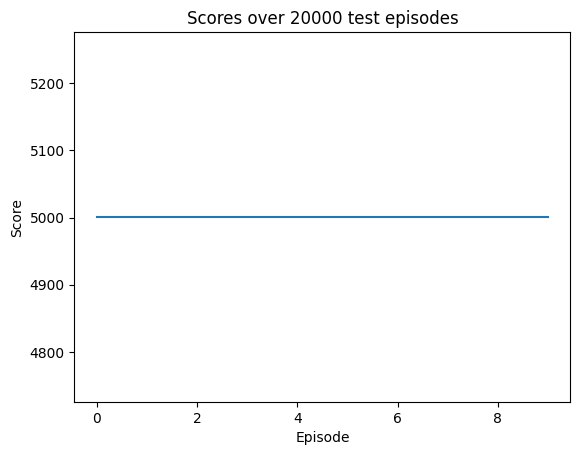

In [78]:
# test the trained MCAgent 
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
n_tests = 10
test_rewards, test_scores = sl_agent.test(env, n_tests)

# rewards
plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_ep} test episodes")
plt.show()

# scores
plt.plot(test_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_ep} test episodes")
plt.show()

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Testing: 100%|██████████| 10/10 [00:00<00:00, 85.47it/s]


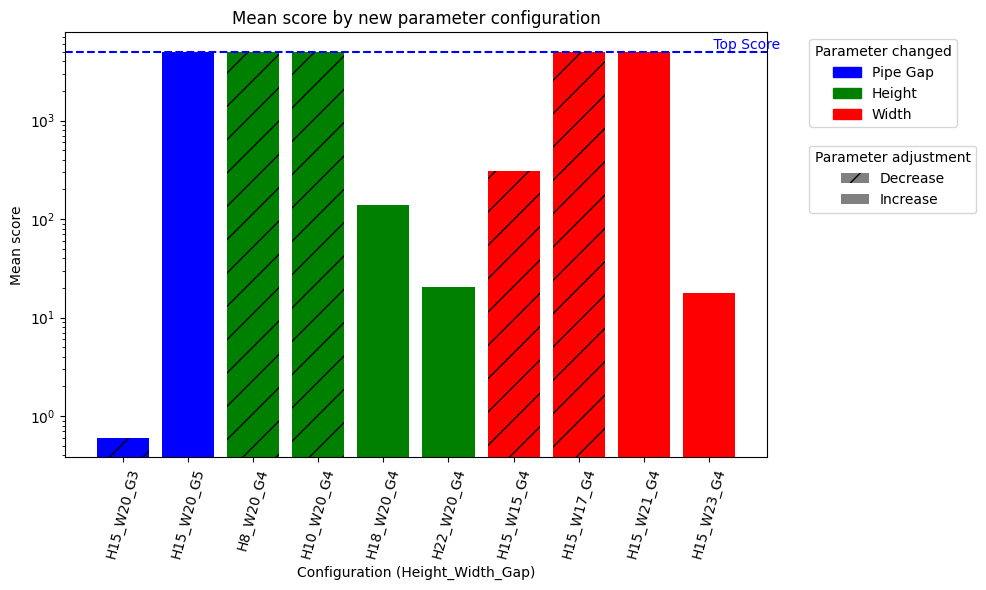

In [79]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Assuming the opmc_agent and its test method are correctly defined and implemented

configs = [
    [15, 20, 3], [15, 20, 5],  # different pipe gap
    [8, 20, 4], [10, 20, 4], [18, 20, 4], [22, 20, 4],  # different height
    [15, 15, 4], [15, 17, 4], [15, 21, 4], [15, 23, 4],  # different width
]

upgrade = [False, True,
           False, False, True, True,
           False, False, True, True
           ]

colors = ['blue', 'blue',  # Pipe gap
          'green', 'green', 'green', 'green', # Height
          'red', 'red', 'red', 'red'  # Width
          ]

color_meanings = {
    'blue': 'Pipe Gap',
    'green': 'Height',
    'red': 'Width'
}

hatch_meanings = {
    '/': 'Decrease',
    '': 'Increase'
}

avg_scores_configs = {}

for elem in configs:
    env = gym.make('TextFlappyBird-v0', height=elem[0], width=elem[1], pipe_gap=elem[2])
    n_tests = 10
    test_rewards, test_scores = sl_agent.test(env, n_tests)  # Assuming this method exists
    avg_scores_configs["H{}_W{}_G{}".format(*elem)] = np.mean(test_scores)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_labels = list(avg_scores_configs.keys())
bar_values = avg_scores_configs.values()

# Create bars with different colors and hatches
for i, (label, value, color, upg) in enumerate(zip(bar_labels, bar_values, colors, upgrade)):
    hatch = '/' if not upg else '' 
    ax.bar(i, value, label=label, color=color, hatch=hatch)

ax.set_xticks(range(len(avg_scores_configs)))
ax.set_xticklabels(bar_labels, rotation=75)
ax.set_xlabel('Configuration (Height_Width_Gap)')
ax.set_ylabel('Mean score')
ax.set_title('Mean score by new parameter configuration')
ax.set_yscale("log")

ax.axhline(y=5000, color='b', linestyle='--')
ax.text(x=len(avg_scores_configs)-1, y=5000, s=" Top Score", color='b', verticalalignment='bottom')

color_patches = [mpatches.Patch(color=color, label=meaning) for color, meaning in color_meanings.items()]
hatch_patches = [mpatches.Patch(facecolor='gray', hatch=hatch, label=meaning) for hatch, meaning in hatch_meanings.items()]
legend1 = plt.legend(handles=color_patches, title="Parameter changed", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().add_artist(legend1)
plt.legend(handles=hatch_patches, title="Parameter adjustment", bbox_to_anchor=(1.05, 0.75), loc='upper left')
plt.tight_layout() 
plt.show()


In [14]:
import time

num_ep_list = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
eps_list = [0.05, 0.1, 0.15, 0.2, 0.3]

eps_perf = {}
eps_times = {}

for eps in eps_list:
    print('Epsilon:', eps)
    score_eps = []
    times_eps = []
    for num_ep in num_ep_list:
        t1 = time.time()
        run_scores = []
        for run in range(20):
            print(f'Run {run+1} for epsilon {eps} with {num_ep} episodes')
            env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
            sl_agent = SarsaLambdaAgent(epsilon=eps)
            sl_agent.train(env, num_ep)
            _, test_scores = sl_agent.test(env, 10)
            run_scores.append(np.mean(test_scores))
        avg_run_score = np.mean(run_scores)
        score_eps.append(avg_run_score)
        t2 = time.time()
        times_eps.append((t2 - t1)/20)
    eps_perf[eps] = score_eps
    eps_times[eps] = times_eps

Testing: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


Run 9 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:00<00:00, 88.46it/s]


Run 10 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:00<00:00, 42.92it/s]


Run 11 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:00<00:00, 17.54it/s]


Run 12 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Run 13 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Run 14 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:00<00:00, 48.78it/s]


Run 15 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:00<00:00, 31.45it/s]


Run 16 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:00<00:00, 38.17it/s]


Run 17 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:00<00:00, 21.83it/s]


Run 18 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:00<00:00, 11.30it/s]


Run 19 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:00<00:00, 54.95it/s]


Run 20 for epsilon 0.3 with 5000 episodes


Testing: 100%|██████████| 10/10 [00:00<00:00, 26.32it/s]


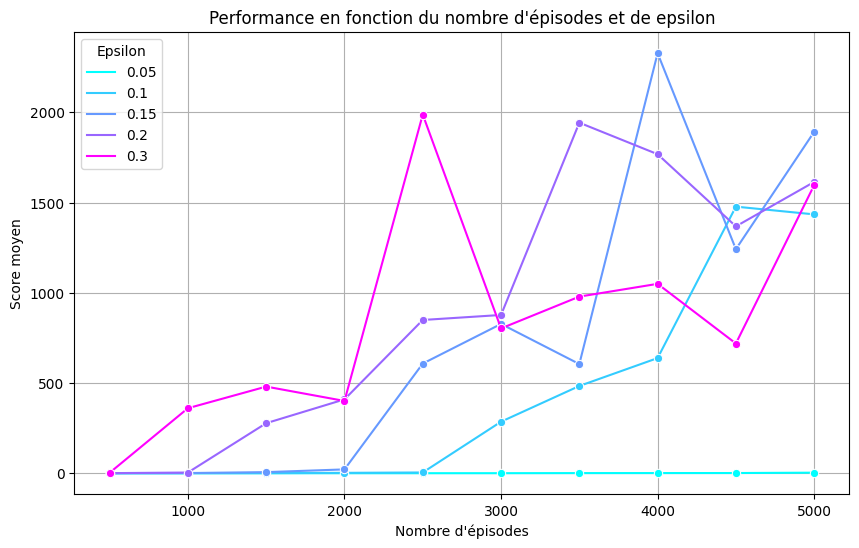

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = []
for eps, scores in eps_perf.items():
    for num_ep, score in zip(num_ep_list, scores):
        data.append({'eps': eps, 'num_ep': num_ep, 'score': score})
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='num_ep', y='score', hue='eps', palette='cool', marker='o')

plt.title("Performance en fonction du nombre d'épisodes et de epsilon")
plt.xlabel("Nombre d'épisodes")
plt.ylabel('Score moyen')
plt.legend(title='Epsilon')
plt.grid(True)

plt.show()

In [59]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
sl_agent = SarsaLambdaAgent(epsilon=0.1)
_, _ = sl_agent.train(env, 18_000)

Training:   0%|          | 41/18000 [00:00<00:45, 398.05it/s]

Training: 100%|██████████| 18000/18000 [33:17<00:00,  9.01it/s]  


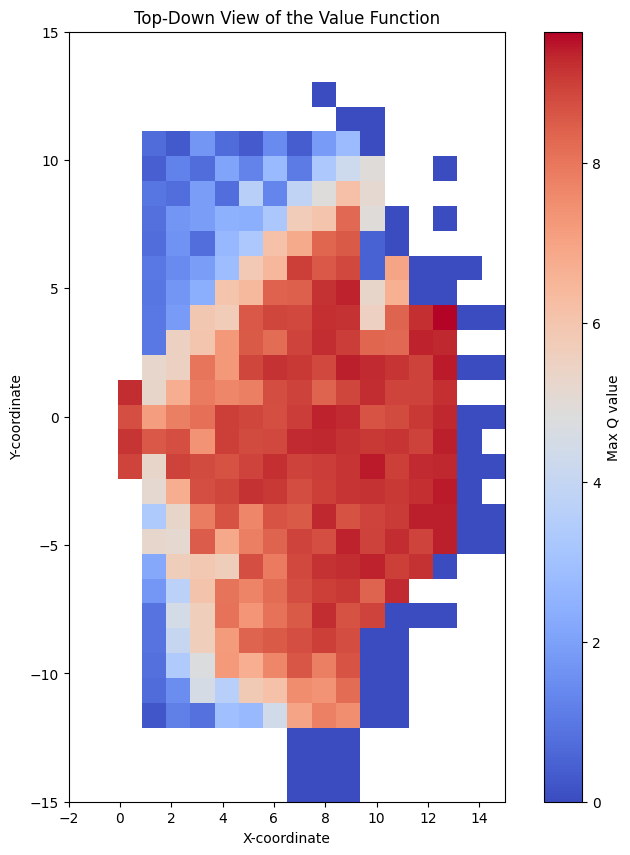

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming sl_agent is an instance of SarsaLambdaAgent that has been trained

def plot_top_view_value_function(agent, min_x = -2, max_x = 15, min_y = -15, max_y = 15):
    """
    Plots the top-down view of the value function from the Q-table of an agent.
    
    Args:
        agent (SarsaLambdaAgent): The agent to plot the value function for.
        min_x (int): The minimum x-coordinate in the environment state space.
        max_x (int): The maximum x-coordinate in the environment state space.
        min_y (int): The minimum y-coordinate in the environment state space.
        max_y (int): The maximum y-coordinate in the environment state space.
    """

    grid = np.full((max_y - min_y + 1, max_x - min_x + 1), np.nan)

    for state, q_values in agent.Q.items():
        x, y = state
        grid_x = x - min_x
        grid_y = y - min_y
        if min_x <= x <= max_x and min_y <= y <= max_y:
            grid[grid_y, grid_x] = np.mean(q_values)  

    # Plot the grid as an image
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap=plt.get_cmap('coolwarm'), interpolation='nearest', origin='lower', extent=[min_x, max_x, min_y, max_y])
    plt.colorbar(label='Max Q value')
    plt.title('Top-Down View of the Value Function')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.show()


plot_top_view_value_function(sl_agent)

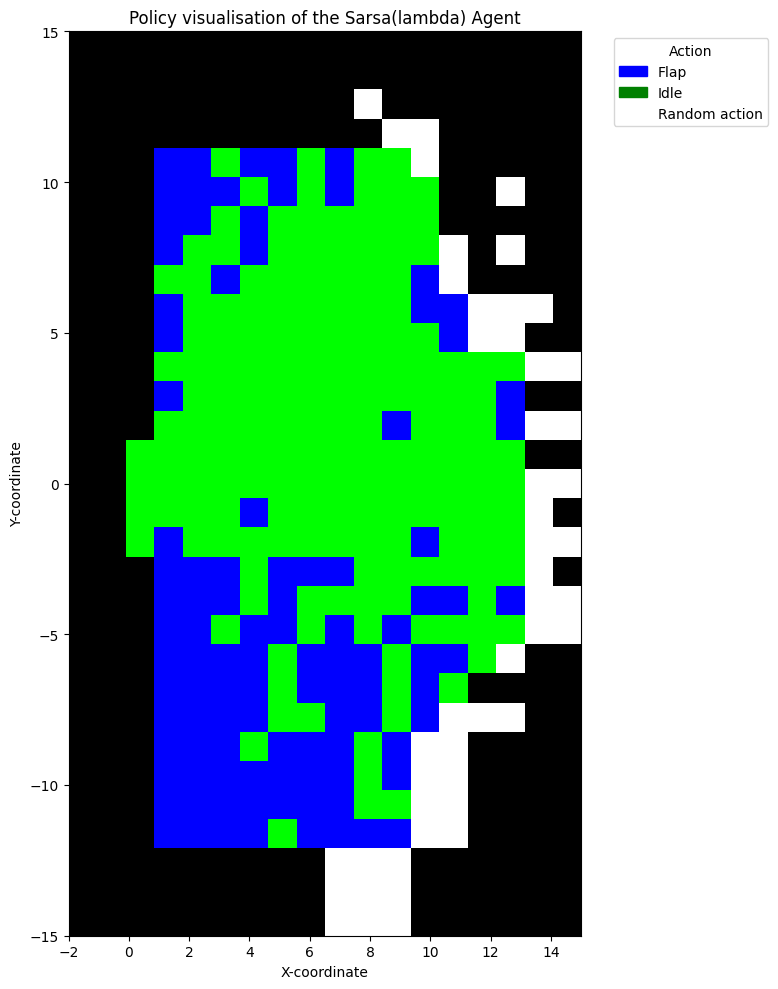

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_view_comparison(agent, min_x=-2, max_x=15, min_y=-15, max_y=15):
    """
    Plots the top-down view comparing q_value[0] and q_value[1] from the Q-table of an agent.
    
    Args:
        agent (SarsaLambdaAgent): The agent to plot the value function for.
        min_x (int): The minimum x-coordinate in the environment state space.
        max_x (int): The maximum x-coordinate in the environment state space.
        min_y (int): The minimum y-coordinate in the environment state space.
        max_y (int): The maximum y-coordinate in the environment state space.
    """
    grid = np.zeros((max_y - min_y + 1, max_x - min_x + 1, 3))  # For RGB colors

    for state, q_values in agent.Q.items():
        x, y = state
        grid_x = x - min_x
        grid_y = y - min_y
        if min_x <= x <= max_x and min_y <= y <= max_y:
            if q_values[0] > q_values[1]:
                grid[grid_y, grid_x] = [0, 0, 1]  # Blue
            elif q_values[1] > q_values[0]:
                grid[grid_y, grid_x] = [0, 1, 0]  # Green
            else:  # If they are equal or both 0
                grid[grid_y, grid_x] = [1, 1, 1]  # White

    # Plot the grid as an image
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, interpolation='nearest', origin='lower', extent=[min_x, max_x, min_y, max_y])
    plt.title('Policy visualisation of the Sarsa(lambda) Agent')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')

    import matplotlib.patches as mpatches
    blue_patch = mpatches.Patch(color='blue', label='Flap')
    green_patch = mpatches.Patch(color='green', label='Idle')
    white_patch = mpatches.Patch(color='white', label='Random action')
    plt.legend(handles=[blue_patch, green_patch, white_patch], title = "Action", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

plot_top_view_comparison(sl_agent)


## Final comparison

In [7]:
import time

num_ep_list = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

opmc_perf = {}
opmc_times = {}

sl_perf = {}
sl_times = {}

for nb_iter in num_ep_list:

    # OPMC AGENT
    t1 = time.time()
    run_scores = []
    for _ in range(15):
        print(f'Run {_+1} for {nb_iter} episodes for OPMC')
        env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
        opmc_agent = OPMCAgent(0.9, 0.1)
        opmc_agent.train(env, nb_iter)
        _, test_scores = opmc_agent.test(env, 10)
        run_scores.append(np.mean(test_scores))
    
    avg_run_score = np.mean(run_scores)

    t2 = time.time()
    times_opmc = (t2 - t1)/15
    opmc_perf[nb_iter] = avg_run_score
    opmc_times[nb_iter] = times_opmc

    # LAMBDA SARSA AGENT
    t1 = time.time()
    run_scores = []
    for _ in range(15):
        print(f'Run {_+1} for {nb_iter} episodes for SL')
        env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
        sl_agent = SarsaLambdaAgent()
        sl_agent.train(env, nb_iter)
        _, test_scores = sl_agent.test(env, 10)
        run_scores.append(np.mean(test_scores))
    
    avg_run_score = np.mean(run_scores)

    t2 = time.time()
    times_sl = (t2 - t1)/15
    sl_perf[nb_iter] = avg_run_score
    sl_times[nb_iter] = times_sl

Testing: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Run 14 for 10000 episodes for SL


Testing: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Run 15 for 10000 episodes for SL


Testing: 100%|██████████| 10/10 [00:00<00:00, 24.51it/s]


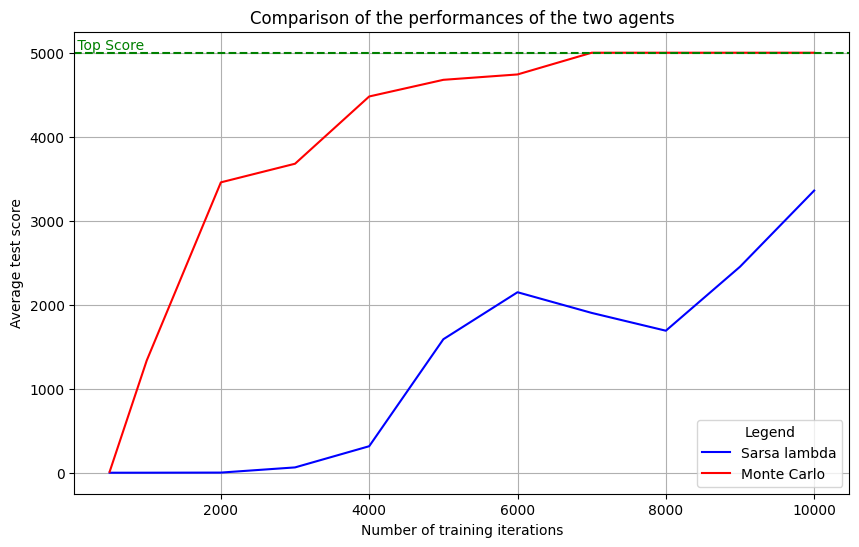

In [25]:
df = pd.DataFrame({'Taille': sl_perf.keys(), 'Sarsa lambda': sl_perf.values(), 'Monte Carlo': opmc_perf.values()})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Taille', y='Sarsa lambda', label='Sarsa lambda', color='blue')
sns.lineplot(data=df, x='Taille', y='Monte Carlo', label='Monte Carlo', color='red')

plt.axhline(y=5000, color='g', linestyle='--')
plt.text(x=len(sl_perf.keys())-1, y=5000, s=" Top Score", color='g', verticalalignment='bottom')

plt.title('Comparison of the performances of the two agents')
plt.xlabel('Number of training iterations')
plt.ylabel('Average test score')
plt.legend(title='Legend')
plt.grid(True)
plt.show()


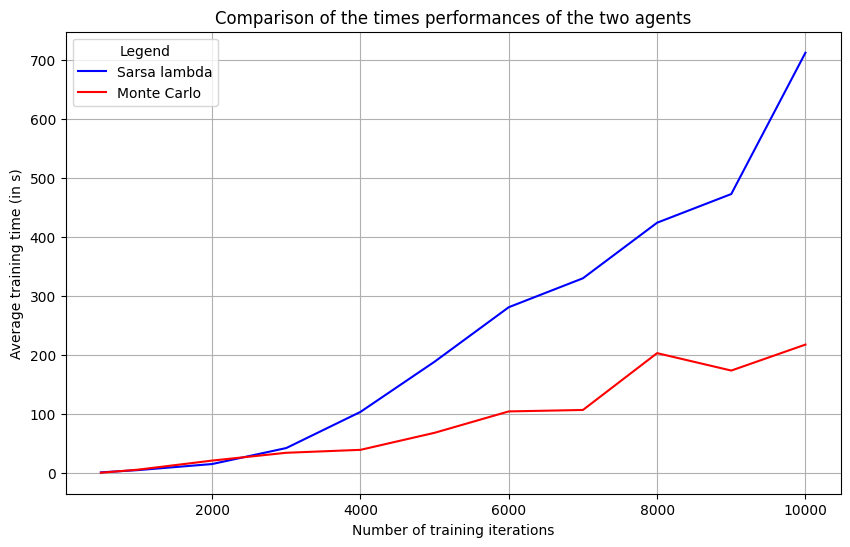

In [33]:
df = pd.DataFrame({'Taille': sl_times.keys(), 'Sarsa lambda': sl_times.values(), 'Monte Carlo': opmc_times.values()})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Taille', y='Sarsa lambda', label='Sarsa lambda', color='blue')
sns.lineplot(data=df, x='Taille', y='Monte Carlo', label='Monte Carlo', color='red')
plt.title('Comparison of the times performances of the two agents')
plt.xlabel('Number of training iterations')
plt.ylabel('Average training time (in s)')
#plt.semilogy()
plt.legend(title='Legend')
plt.grid(True)
plt.show()
